This homework will guide you through a complete additive model analysis of a time series and familiarize you with the (fairly new) [Facebook Prophet](https://facebook.github.io/prophet/) package for time series analysis. 

Prophet simplifies the implementation of analysis like "Structural Time Series modeling" and/or "Bayesian dynamic linear model": similarly to the ARMA family of models, these models attempt to recreate (and predict) a time series by linearly combining variouos components: trends, seasonalities, but also regression on exogenous variables. In this case, we will see if Uber rides area affected by weather, in additional to trends and seasonality. 

Under the hood, the model will implement an optimization to find the best fit parameters for each component (mostly the relative amplitude of each component) in a Bayesian framework, either as a direct optimization which is possible since the model is linear, or by MCMC (https://github.com/facebook/prophet/issues/669)

Note that the 4 models you will create build incrementally: you are always adding one more piece of a model to the previous one (even when it is not explicitly stated that the new model contains all the components of the previous ones:
- Model 1: trend and seasonality
- Model 2: trend, seasonality, and exogenous weather variables
- Model 3: trend, seasonality, exogenous weather variables, holidays
- Model 4: trend, seasonality, exogenous weather variables, holidays, MCMC implementation (same model, different optimization)



## Uber rides area affected by weather, in additional to trends and seasonality

In [2]:
import pandas as pd
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


 
# DATA ANALYSIS 0: we will use the package Prohpet, created by facebook for time series analysis. 
Install the package and import it. The model that you will use is Prophet. Also import the diagnostics package from fbprophet


In [3]:
!pip install fbprophet


In [0]:
import fbprophet

In [0]:
from fbprophet import Prophet
from fbprophet import diagnostics

# 1. DATA ACQUISITION 1: write a for loop that extracts files from the repository https://github.com/fivethirtyeight/uber-tlc-foil-response. 

There are a number of csv files in the repository, and a zip file. Read in within the loop the 6 csv files representing uber pickup deives from April to September 2014. This can be done with a for loop iterating in a container that contains the apporopriate string identified in the file names (e.g. 'apr' for April) and composes the string using an immutable root, the month name, and the immutable ending of the file. Remember to read in the raw files. Remember that ```pd_read_csv ()``` accepts URLs, so you do not have to download the data.

At the end you need the data to be appended into a single datafraom (note: appended, i.e. concatenated, not merged.) You can achieve this in many ways, an easy (and a bit lazy one) is to append each file read in as a dataframe to a list and use ```pd.concat(list)``` to concatenate them into a single dataframe.

In [0]:
c = []

for mon in ['apr', 'may', 'jun', 'jul', 'aug', 'sep']:
  b=[]
  b=pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-'+mon+'14.csv')
  c.append(b)


In [7]:
c

[                 Date/Time      Lat      Lon    Base
 0         4/1/2014 0:11:00  40.7690 -73.9549  B02512
 1         4/1/2014 0:17:00  40.7267 -74.0345  B02512
 2         4/1/2014 0:21:00  40.7316 -73.9873  B02512
 3         4/1/2014 0:28:00  40.7588 -73.9776  B02512
 4         4/1/2014 0:33:00  40.7594 -73.9722  B02512
 ...                    ...      ...      ...     ...
 564511  4/30/2014 23:22:00  40.7640 -73.9744  B02764
 564512  4/30/2014 23:26:00  40.7629 -73.9672  B02764
 564513  4/30/2014 23:31:00  40.7443 -73.9889  B02764
 564514  4/30/2014 23:32:00  40.6756 -73.9405  B02764
 564515  4/30/2014 23:48:00  40.6880 -73.9608  B02764
 
 [564516 rows x 4 columns],
                  Date/Time      Lat      Lon    Base
 0         5/1/2014 0:02:00  40.7521 -73.9914  B02512
 1         5/1/2014 0:06:00  40.6965 -73.9715  B02512
 2         5/1/2014 0:15:00  40.7464 -73.9838  B02512
 3         5/1/2014 0:17:00  40.7463 -74.0011  B02512
 4         5/1/2014 0:17:00  40.7594 -73.9734  B0251

In [0]:
uberrides = pd.concat(c,ignore_index=True)

In [9]:
uberrides.shape

(4534327, 4)

# DATA PREPARATION 1: convert the dates to datetime and generate a time series of rides/day. 
Note that at this stage this is not the kind of time series you need. You need number of rides per unit time (e.g. per day) and we have timsetamp of each ride. 
To obtain that you can use the ```groupby()``` method of your dataframe. Before that, convert the date time column to ```pd.datetime``` type (this may take a while), then you can use groupby with the "date" attribute, which means grouping by day, and use the method count of groupby to count the number of rides in each group. 

Finally, rename the dataframe so that the number of rides is column ```y``` and the dates are column ```ds``` - this is required by the prophet package that you will use for the enalysis.

** plot the resulting dataframe

In [10]:
uberrides.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [11]:
uberrides.columns

Index(['Date/Time', 'Lat', 'Lon', 'Base'], dtype='object')

In [0]:
uberrides["time"] = pd.to_datetime(uberrides['Date/Time'])

In [13]:
uberrides.iloc[0]['time'].date

<function Timestamp.date>

In [0]:
uberbyday = uberrides.groupby(uberrides["time"].dt.date).count()

In [15]:
uberbyday

,Date/Time,Lat,Lon,Base,time
time,,,,,
2014-04-01,14546,14546,14546,14546,14546
2014-04-02,17474,17474,17474,17474,17474
2014-04-03,20701,20701,20701,20701,20701
2014-04-04,26714,26714,26714,26714,26714
2014-04-05,19521,19521,19521,19521,19521
...,...,...,...,...,...
2014-09-26,37504,37504,37504,37504,37504
2014-09-27,39468,39468,39468,39468,39468
2014-09-28,29656,29656,29656,29656,29656


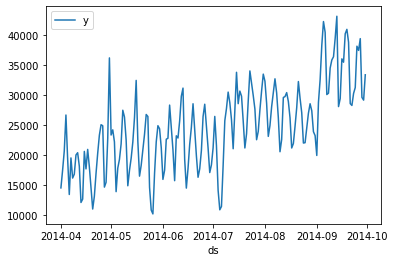

In [16]:
uberbyday['y']=uberbyday['Lat']
uberbyday['ds']=uberbyday.index
uberbyday.plot(x="ds", y="y");

**Figure 1.** The number of uber rides by day. Day is represented on the x axis while the number of rides is labeled on the y axis.


# DATA PREPARATION 2: stanardize the data
Subtract the mean and divide by the standard eviation the ```y``` column. Although this is not strictly necessary to work with the Prophet package, it is in general recommanded not to use large numbers in your analysis. furtehrmore, this will convert the target variable to a floating point, which is a better type for regression

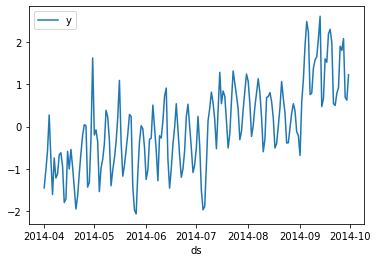

In [17]:
uberbyday['y']=(uberbyday['y']-mean(uberbyday['y']))/std(uberbyday['y'])
uberbyday.plot(x="ds", y="y");

**Figure 2.** The number of uber rides by day standardized. Day is represented on the x axis while the standardized number of rides is labeled on the y axis. 

# DATA ANALYSIS fit the uber rides data with the prophet model. 
# MODEL 1: trends and seasonality
The model will look for seasonality and trends automatically. It is a bit of a black box and I dont have a lot of experience with it, but it is really "cutting edge" in this field.
As with any object oriented package, you first need to invoke ```Phrophet()``` to create a model, call it ```simplem```, then fit it to the uber data. Forecast 1 month past the last available datapoint and print the last 5 entries of the resulting dataframe. Plot the forecast, including the uncertainty regions of the forecast and the comonents of the forcast which should be the trend and the weekly seanality. The model should naturally produce these components. If it does not look into the model and the settings by displaying the model methods (e.g. type ```siplemodel.``` and press the tab key.) Remember that ou MUST describe what you see in these plots!


In [18]:
simplem = Prophet()
simplem.fit(uberbyday)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future=simplem.make_future_dataframe(freq='D',periods=30)

In [20]:
future

,ds
0,2014-04-01
1,2014-04-02
2,2014-04-03
3,2014-04-04
4,2014-04-05
...,...
208,2014-10-26
209,2014-10-27
210,2014-10-28
211,2014-10-29


In [0]:
forecast=simplem.predict(future)

In [22]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
208,2014-10-26,0.669734,0.032495,1.336750
209,2014-10-27,0.950388,0.296163,1.612962
210,2014-10-28,1.530945,0.857250,2.220133
211,2014-10-29,1.890402,1.235183,2.572164
212,2014-10-30,2.211355,1.547871,2.898718


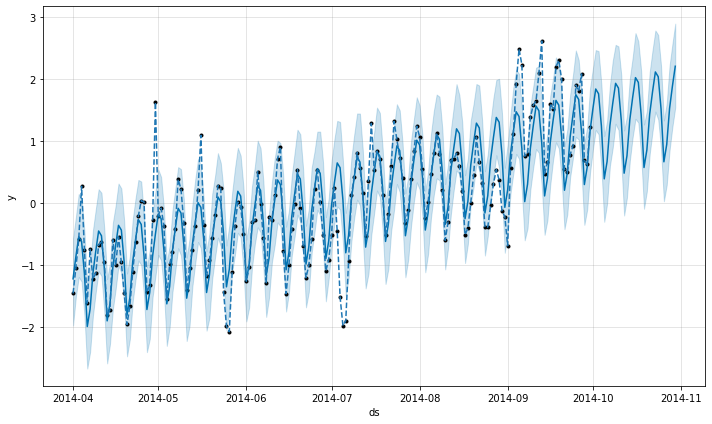

In [23]:
fig1 = simplem.plot(forecast)
pl.plot(uberbyday.y, '--');

***Figure 4.*** The figure shows forcast by prophet (solid) when fitted to the data (dashed)considering only data trend and seasonality.

 

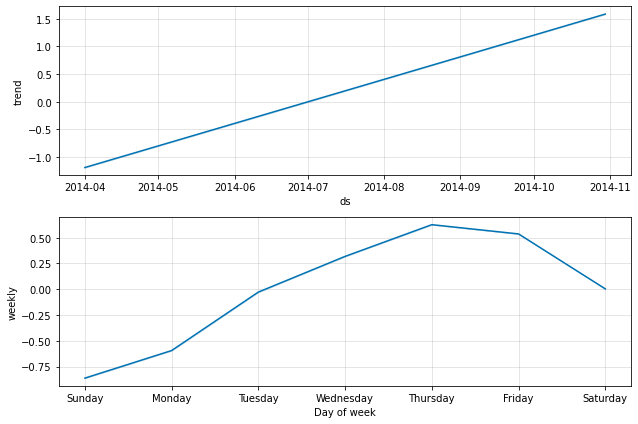

In [24]:
fig2 = simplem.plot_components(forecast)


***Figure 5.*** The top figure shows data trend over the considered months i.e. from April to Spetember. We do see an increased trend in the data over months. However the bottom figure shows weekly behavior of the data which shows a peak on Thursday and minimum value on Sunday. The bottom figure therefore implies that uber rides are not profitale as much on SUnday as is on Thursday of the week. 

# DATA ANALYSIS: model validatoin
 Crossvaliate your model and create a function to evaluate the goodness of fit of your model. 
Use the chisquare per degree of freedom (also calle reduced chi square, note that this quantity has a theoretical expectation value of 1 for a perfect model): the chi square divided by the number of observations.Use 30 days for crossvalidation. The diagnostics function will return all that you need to calculate your reduce chi2. Howeve, we o not have the uncertainties to put them in the formula (we could create them from count statistics, but I wont ask you to) so set the uncertainties to 1. With unerestimated uncertainties this quantity is likely to be less than 1.

You can read about cross valiation for regression here https://robjhyndman.com/hyndsight/tscv/ (but do not set the period=1 or the process would take too long)

In [25]:
uberbyday

,Date/Time,Lat,Lon,Base,time,y,ds
time,,,,,,,
2014-04-01,14546,14546,14546,14546,14546,-1.453505,2014-04-01
2014-04-02,17474,17474,17474,17474,17474,-1.037558,2014-04-02
2014-04-03,20701,20701,20701,20701,20701,-0.579136,2014-04-03
2014-04-04,26714,26714,26714,26714,26714,0.275062,2014-04-04
2014-04-05,19521,19521,19521,19521,19521,-0.746764,2014-04-05
...,...,...,...,...,...,...,...
2014-09-26,37504,37504,37504,37504,37504,1.807871,2014-09-26
2014-09-27,39468,39468,39468,39468,39468,2.086874,2014-09-27
2014-09-28,29656,29656,29656,29656,29656,0.692997,2014-09-28


In [0]:
diagnostics.cross_validation?

In [27]:
def rchi2(y, ytrue):
  res=sum((y-ytrue)**2/len(y))
  return res
cvresult_simplem = diagnostics.cross_validation(simplem, horizon='92D', period='15D', initial='30D')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-01 00:00:00 and 2014-06-30 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


In [28]:
cvresult_simplem

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-05-02,0.147235,-0.504918,0.794904,-0.077101,2014-05-01
1,2014-05-03,-0.316838,-0.955270,0.300950,-0.361360,2014-05-01
2,2014-05-04,-1.237760,-1.860053,-0.615371,-1.542718,2014-05-01
3,2014-05-05,-0.897065,-1.461549,-0.244539,-0.982865,2014-05-01
4,2014-05-06,-0.376283,-0.996768,0.186781,-0.778159,2014-05-01
...,...,...,...,...,...,...
455,2014-09-26,1.176419,0.678213,1.748408,1.807871,2014-06-30
456,2014-09-27,0.435886,-0.128294,0.979703,2.086874,2014-06-30
457,2014-09-28,-0.378057,-0.895614,0.141898,0.692997,2014-06-30
458,2014-09-29,-0.025295,-0.557965,0.528579,0.628361,2014-06-30


In [29]:
rchi2(cvresult_simplem.y,cvresult_simplem.yhat)

0.7236729441145245

# DATA ACQUISITION 2: dooownload exogenous variable data. 
One may guess that weather would affect the number of rides: a trivial example is that if it rains people are less likely to walk. It might not be that trivial tho, maybe if it  rains people are altogether less likely to go out.

Acquire weather data for NYC for the relevant time period from the www.worldweatheronline.com website through the wwo_hist API. You will have to 1) request a key https://www.worldweatheronline.com/developer/api/, https://www.worldweatheronline.com/developer/signup.aspx ( it is free for <500 requests).
an install and import the ```wwo_hist``` package

Save your key in a separate file and read it in. For example, you can create a file ```my_apis.csv``` in the same folder where you are working and the content of the file can be ```wwo,XXXXXXXXXXXXXXXXX```

This should download a ```New+york,ny.csv``` file which you can then read in. Convert the atetime entry to pd.datetime as you did before and merge the uber reides and the weather dataframe on the date feature. YOud rataframe should now have columns ```y, ds, tempC, precipMM```. You should stanardize the tempC and precipMM features as you did for the number of rides.

Plot each feature.

In [30]:
!pip install wwo_hist

In [0]:
from wwo_hist import retrieve_hist_data

In [32]:
from google.colab import drive

drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [33]:
cd gdrive/My\ Drive

/content/gdrive/My Drive


In [0]:
!rm my_apis*.csv

In [0]:
# Getting API key
!echo "wwo,db781420ba4c404897b195813201703" >> my_apis.csv

In [36]:
!cat my_apis.csv

wwo,db781420ba4c404897b195813201703


In [37]:
frequency = 24 #fewquency in hours
start_date = '2014-04-01'
end_date = '2014-09-30'
api_key = pd.read_csv("my_apis.csv", header=None, index_col=0).loc["wwo"].values[0]
location_list = ['New+york,ny']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True)



Retrieving weather data for New+york,ny


Currently retrieving data for New+york,ny: from 2014-04-01 to 2014-04-30
Time elapsed (hh:mm:ss.ms) 0:00:01.259910
Currently retrieving data for New+york,ny: from 2014-05-01 to 2014-05-31
Time elapsed (hh:mm:ss.ms) 0:00:02.640639
Currently retrieving data for New+york,ny: from 2014-06-01 to 2014-06-30
Time elapsed (hh:mm:ss.ms) 0:00:03.981549
Currently retrieving data for New+york,ny: from 2014-07-01 to 2014-07-31
Time elapsed (hh:mm:ss.ms) 0:00:05.341469
Currently retrieving data for New+york,ny: from 2014-08-01 to 2014-08-31
Time elapsed (hh:mm:ss.ms) 0:00:06.693323
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:07.955010
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:08.671769


export New+york,ny completed!




In [38]:
!ls *.csv

'Copy of Employees.csv'   subperson_img_url.csv
'Copy of mpg.csv'	  subtrafficsign_img_url.csv
 gender_place.csv	  subtruck_img_url.csv
 LALNeq.csv		  test.csv
 my_apis.csv		  train-annotations-bbox.csv
 New+york,ny.csv	  train.csv
 subcar_img_url.csv	  train-images-boxable.csv


In [39]:
pd.read_csv("my_apis.csv", header=None, index_col=0).loc["wwo"].values[0]

'db781420ba4c404897b195813201703'

In [0]:
weather = pd.read_csv("New+york,ny.csv")

In [41]:
weathershort = None
weathershort = pd.DataFrame({'temperaturec':(weather.tempC-weather.tempC.mean())/weather.tempC.std(), 'rainfall':(weather.precipMM-weather.precipMM.mean())/weather.precipMM.std()})
weathershort.set_index(pd.to_datetime(weather.date_time), inplace=True)
#uberrides["time"] = pd.to_datetime(uberrides["Date/Time"])
weathershort.head()

,temperaturec,rainfall
date_time,,
2014-04-01,-1.959822,-0.484962
2014-04-02,-1.959822,-0.430609
2014-04-03,-1.766830,-0.484962
2014-04-04,-3.117776,0.737969
2014-04-05,-2.345807,-0.457786


In [0]:
uberweather = uberbyday.join(weathershort)

In [43]:
print(weather)

      date_time  maxtempC  mintempC  ...  visibility  winddirDegree  windspeedKmph
0    2014-04-01        12         2  ...          10            269             11
1    2014-04-02        12         4  ...           9            208              6
2    2014-04-03        13         6  ...          10            209              7
3    2014-04-04         6         5  ...           9             96             15
4    2014-04-05        10         3  ...           9            259             19
..          ...       ...       ...  ...         ...            ...            ...
208  2014-09-26        23        13  ...          10             58             11
209  2014-09-27        25        15  ...          10            161              7
210  2014-09-28        26        15  ...          10            206              6
211  2014-09-29        24        17  ...          10            248              6
212  2014-09-30        21        17  ...           7            146              8

[21

In [44]:
#leave
uberweather

,Date/Time,Lat,Lon,Base,time,y,ds,temperaturec,rainfall
2014-04-01,14546,14546,14546,14546,14546,-1.453505,2014-04-01,-1.959822,-0.484962
2014-04-02,17474,17474,17474,17474,17474,-1.037558,2014-04-02,-1.959822,-0.430609
2014-04-03,20701,20701,20701,20701,20701,-0.579136,2014-04-03,-1.766830,-0.484962
2014-04-04,26714,26714,26714,26714,26714,0.275062,2014-04-04,-3.117776,0.737969
2014-04-05,19521,19521,19521,19521,19521,-0.746764,2014-04-05,-2.345807,-0.457786
...,...,...,...,...,...,...,...,...,...
2014-09-28,29656,29656,29656,29656,29656,0.692997,2014-09-28,0.742069,-0.484962
2014-09-29,29201,29201,29201,29201,29201,0.628361,2014-09-29,0.356084,-0.457786
2014-09-29,29201,29201,29201,29201,29201,0.628361,2014-09-29,0.356084,-0.457786
2014-09-30,33431,33431,33431,33431,33431,1.229268,2014-09-30,-0.222892,-0.267552


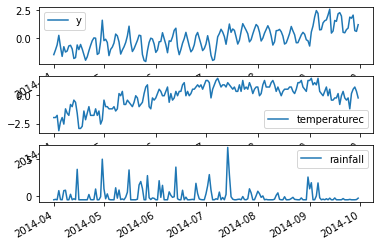

In [45]:
fig, ax = pl.subplots(3)
uberweather.plot(y="y", ax=ax[0])
uberweather.plot(y="temperaturec", ax=ax[1])
uberweather.plot(y="rainfall", ax=ax[2])

**Figure 5.** The time series for standardized versions of uber rides, temperature, and rainfall by month. The top panel represents the standardized number of uber rides on the y axis, and the date on the x axis. The middle panel represents the standarized temprtature on the y axis and the date on the x axis. The bottom panel represents the standardized rainfall on the y axis and the date on the x axis. 

   # MODEL 2: create a new Prophet model and add to it tempC and precipMM as regressors
Use the model method ```model.add_regressor()```. Call the model ```regrm```. Fit the model and cross valiate it. Plot the 2 models and calculate the reduced chi2 for each model and compare. Note that here you should not forecast, since you do not have the future values of the weather. If you wanted to go through the trouble to get future weather and forecast that is definitely a good extra credit!

In [46]:
regrm = Prophet()
regrm.add_regressor('temperaturec')
regrm.add_regressor('rainfall')

In [47]:
regrm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


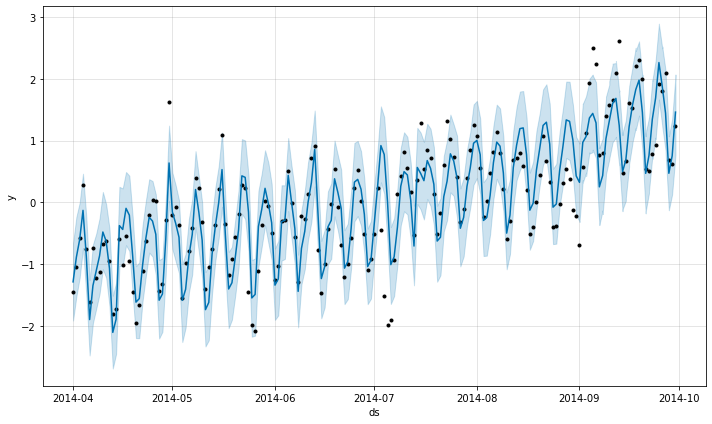

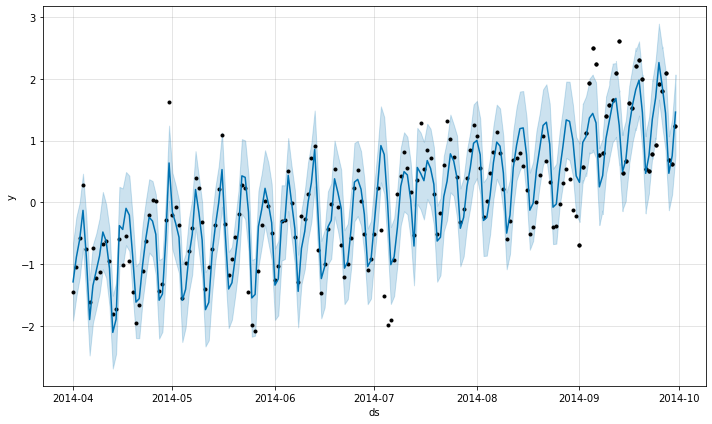

In [48]:
nowcast = regrm.predict(uberweather)
simplem.plot(nowcast)
regrm.plot(nowcast);


**Figure 6**. The top panel represents the standardized number of uber rides by day. The date is represented on the x axis while the standardized number of rides is labeled on the y axis. Uncertainty is represented as the light blue coloring.The bottom panel represents the standardized number of uber rides considering temperature and rainfall. The date is represented on the x axis while the standardized number of rides is labeled on the y axis. Uncertainty is represented as the light blue coloring.

In [49]:
cvresult_model2 = diagnostics.cross_validation(regrm, initial='92D', period='15D', horizon='30D')
chisq_val = rchi2(cvresult_model2.y, cvresult_model2.yhat)
print(chisq_val)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


0.48354207181675335


# MODEL 3 add holidays
Holiday of course affect traffic and ridership. Prophoet has very convenient functionality to put in holidays! This a huge simplification of the workflow in timeseries analysis! add holidays for ths us with the model ```model.add_country_holidays()``` which takes argument ```country_name="US"``` in the case of the US. Once again, fit, predict, plot, crossvalidate, calculate and compare the reduced chi2


In [50]:
regholm = Prophet()
regholm.add_regressor('temperaturec')
regholm.add_regressor('rainfall')
regholm.add_country_holidays(country_name="US")
regholm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [51]:
print(regholm)

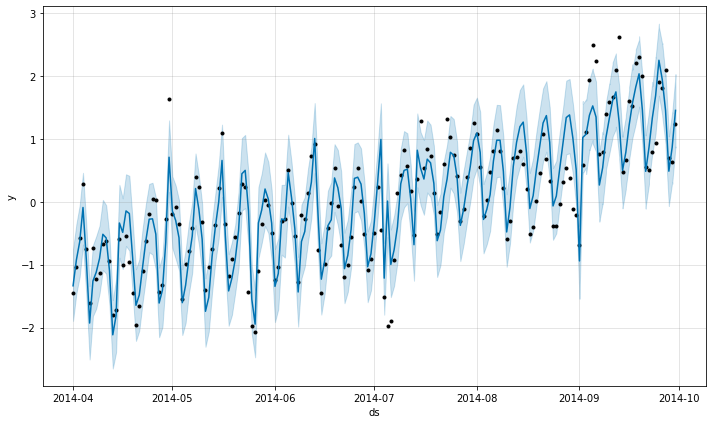

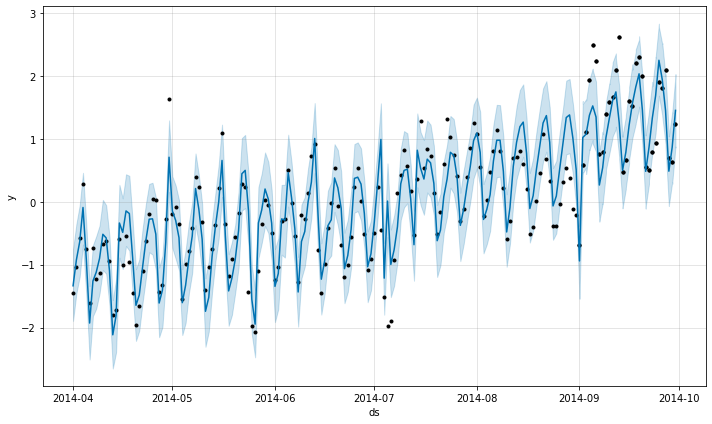

In [52]:
nowcast2 = regholm.predict(uberweather)
simplem.plot(nowcast2)
regholm.plot(nowcast2);

**Figure 7.** The top panel represents the standardized number of uber rides by day. The date is represented on the x axis while the standardized number of rides is labeled on the y axis. Uncertainty is represented as the light blue coloring.The bottom panel represents the standardized number of uber rides considering temperature, rainfall, and holidays. The date is represented on the x axis while the standardized number of rides is labeled on the y axis. Uncertainty is represented as the light blue coloring.

In [53]:
cvresult_model3 = diagnostics.cross_validation(regholm, initial='92D', period='15D', horizon='30D')
chisq_val = rchi2(cvresult_model3.y, cvresult_model3.yhat)
print(chisq_val)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


0.42309891258089927


# MODEL 4: this whole thing can be done with MCMC optimization in a fully bayesian framework. 
Add the argument mcmc_samples=5000 to Propher in your next model and see how it goes. Make the usual plots and calculate the reduced chi2 one last time

In [54]:
regmcmc = Prophet(mcmc_samples=5000)
regmcmc.add_regressor('temperaturec')
regmcmc.add_regressor('rainfall')
regmcmc.add_country_holidays(country_name="US")
regmcmc.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


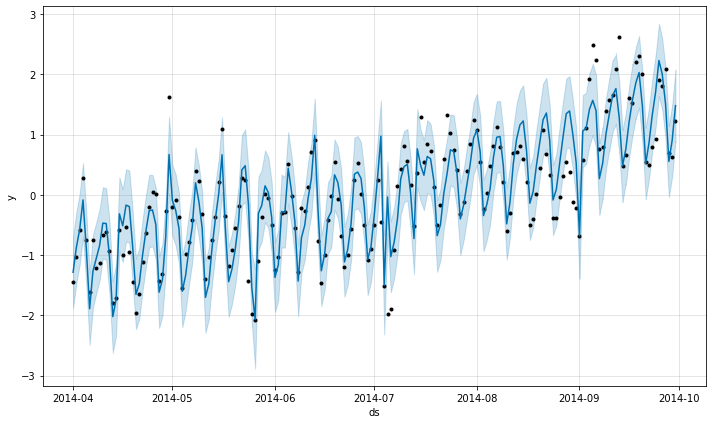

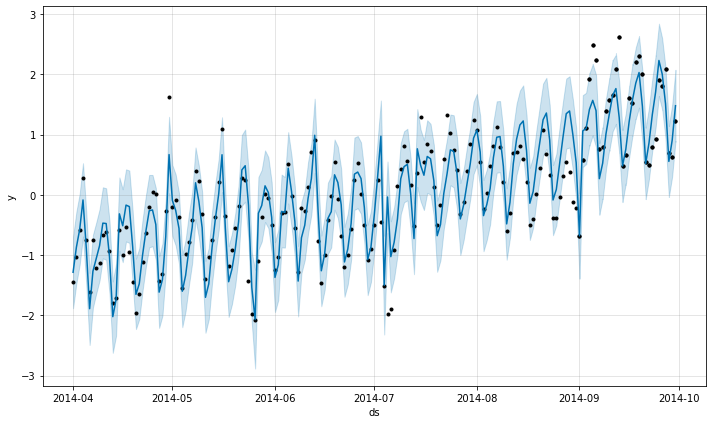

In [55]:
nowcast3 = regmcmc.predict(uberweather)
simplem.plot(nowcast3)
regmcmc.plot(nowcast3);

Figure 8. The top panel represents the standardized number of uber rides by day. The date is represented on the x axis while the standardized number of rides is labeled on the y axis. Uncertainty is represented as the light blue coloring.The bottom panel represents the standardized number of uber rides considering temperature, rainfall, and holidays. The date is represented on the x axis while the standardized number of rides is labeled on the y axis. Uncertainty is represented as the light blue coloring.

In [56]:
cvresult_model4 = diagnostics.cross_validation(regmcmc, initial='92D', period='15D', horizon='30D')
chisq_val = rchi2(cvresult_model4.y, cvresult_model4.yhat)
print(chisq_val)


#rchi2(nowcast3.trend, nowcast3.yhat)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


0.49872010882911433


# Extra Credit
There are two packages with similar functionalities. As extra credit, repeat some of the steps of this analysis with either: Tensorflow timeseries modeling https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html or https://github.com/wwrechard/pydlm